In [1]:
import numpy as np
from collections import defaultdict
from scipy.stats import poisson

In [2]:
print(poisson.cdf(21,2))
print(poisson.cdf(22,2))

0.9999999999999994
1.0


For all intents and purposes the CDF of Poisson (with $\lambda=2$ like in these simulations) is already equal to $1$. (At least computer isn't going to give any functionally different answer. So its (negative) logarithm will always be $0$. So while it technically isn't correct to omit that term from calculation of approximate (logarithmic) fudge factor, it's always going to equal $0$, so that's why it's omitted.

In [3]:
print(np.log(poisson.cdf(21,2)))
print(np.log(poisson.cdf(22,2)))

-5.551115123125785e-16
0.0


Like there basically is no way we are ever to get down to fewer than 22 cells, starting with 50 million cells and only forming 15 million droplets. The probability is so negligible that the computer probably doesn't have enough entropy to simulate it.

In [4]:
rng = np.random.default_rng(42)

freq_vector = np.array([.0001, .0001, .0002, .0002, .0005, .0005, .001, .001, .002, .002, .005, .005, .01, .01, .02, .02, .05, .05, .1, .1, .2, .2, .2224])
population_size = 50000000
population = np.floor(population_size * freq_vector).astype(int)

In [5]:
population

array([    5000,     5000,    10000,    10000,    25000,    25000,
          50000,    50000,   100000,   100000,   250000,   250000,
         500000,   500000,  1000000,  1000000,  2500000,  2500000,
        5000000,  5000000, 10000000, 10000000, 11120000])

In [6]:
# Python's ducktyping combined with NumPy's ability to do everything entrywise is very nice here
Phi = lambda x, C: (C - x + 0.5)*(np.log(C) - np.log(C - x))

In [7]:
def lower_general_log_Robbins_bound(numerator_vector, denominator_vector):
    """NumPy doing things like reciprocals entrywise is very helpful here"""
    # need to be careful: https://stackoverflow.com/a/10384785
    # although I checked and that behavior seems possibly outdated
    result = 0.
    result += 1. / ((12.*np.sum(numerator_vector)) + 1.)
    result -= np.sum(1. / (12.*numerator_vector))
    result -= 1. / (12*np.sum(denominator_vector))
    result += np.sum(1. / ((12.*denominator_vector) + 1.))
    return result

def lower_log_Robbins_bound(population, droplet):
    numerator_vector = population - droplet
    denominator_vector = population
    return lower_general_log_Robbins_bound(numerator_vector, denominator_vector)

def upper_general_log_Robbins_bound(numerator_vector, denominator_vector):
    return -lower_general_log_Robbins_bound(denominator_vector, numerator_vector)

def upper_log_Robbins_bound(population, droplet):
    numerator_vector = population - droplet
    denominator_vector = population
    return upper_general_log_Robbins_bound(numerator_vector, denominator_vector)

In [8]:
def logarithmic_fudge_factors(population, droplet):
    approx_logarithmic_fudge_factor = np.sum(Phi(droplet,population)) - Phi(np.sum(droplet),np.sum(population))
    logarithmic_fudge_factor_lower_bound = approx_logarithmic_fudge_factor + lower_log_Robbins_bound(population, droplet)
    logarithmic_fudge_factor_upper_bound = approx_logarithmic_fudge_factor + upper_log_Robbins_bound(population, droplet)
    # Somewhat misleading because `approx_logarithmic_fudge_factor` only lies between the two when the
    # `lower_log_Robbins_bound(population, droplet)` is negative, which to the best of my understanding is not always
    return (logarithmic_fudge_factor_lower_bound, approx_logarithmic_fudge_factor, logarithmic_fudge_factor_upper_bound)

In [9]:
number_droplets = 15000000

In [10]:
droplet_indices = defaultdict(list)

logarithmic_fudge_factor_lower_bounds = np.zeros(number_droplets)
approx_logarithmic_fudge_factors = np.zeros(number_droplets)
logarithmic_fudge_factor_upper_bounds = np.zeros(number_droplets)

In [11]:
%%time
for iteration in range(1,number_droplets+1):
    num_cells = rng.poisson(lam=2)
    while num_cells > np.sum(population):
        num_cells = rng.poisson(lam=2)
        
    droplet = rng.multivariate_hypergeometric(colors=population, nsample=num_cells)
    
    logarithmic_fudge_factor_lower_bounds[iteration-1], approx_logarithmic_fudge_factors[iteration-1], logarithmic_fudge_factor_upper_bounds[iteration-1] = logarithmic_fudge_factors(population, droplet)
    
    # OK before subtracting the droplet off of the droplet, this is the part where I would need to compute the (approximate) logarithmic fudge factors.
    
    population -= droplet
    
    for counter, entry in enumerate(droplet != 0):
        if entry == True:
            droplet_indices[counter].append(iteration)

CPU times: user 1h 3min 9s, sys: 27.4 s, total: 1h 3min 37s
Wall time: 1h 3min 43s


In [12]:
import matplotlib.pyplot as plt

## Approximate Logarithmic Fudge Factors

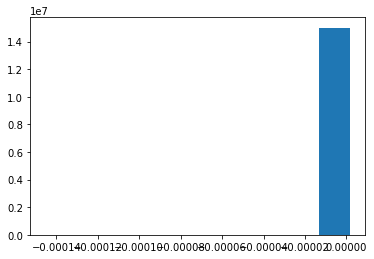

In [13]:
plt.hist(approx_logarithmic_fudge_factors)
plt.show()

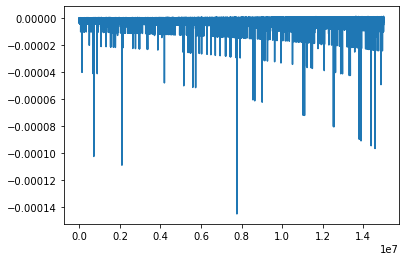

In [14]:
plt.plot(np.arange(number_droplets), approx_logarithmic_fudge_factors)
plt.show()

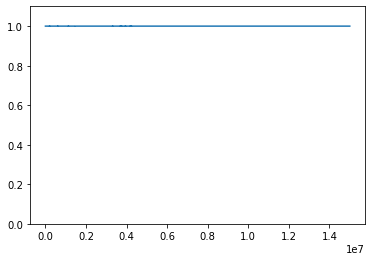

In [15]:
plt.plot(np.arange(number_droplets), np.exp(approx_logarithmic_fudge_factors))
plt.ylim((0,1.1))
plt.show()

## Logarithmic Fudge Factors -- Lower Bounds

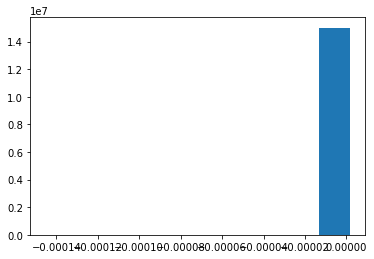

In [16]:
plt.hist(logarithmic_fudge_factor_lower_bounds)
plt.show()

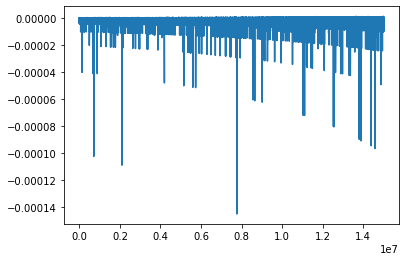

In [17]:
plt.plot(np.arange(number_droplets), logarithmic_fudge_factor_lower_bounds)
plt.show()

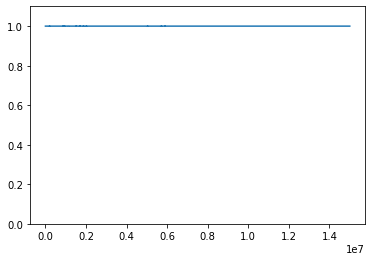

In [18]:
plt.plot(np.arange(number_droplets), np.exp(logarithmic_fudge_factor_lower_bounds))
plt.ylim((0,1.1))
plt.show()

## Logarithmic Fudge Factors -- Upper Bounds

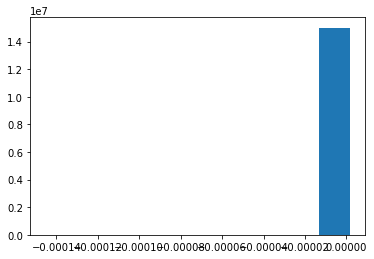

In [19]:
plt.hist(logarithmic_fudge_factor_upper_bounds)
plt.show()

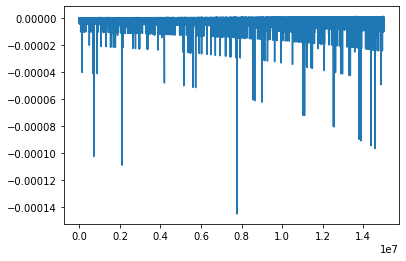

In [20]:
plt.plot(np.arange(number_droplets), logarithmic_fudge_factor_upper_bounds)
plt.show()

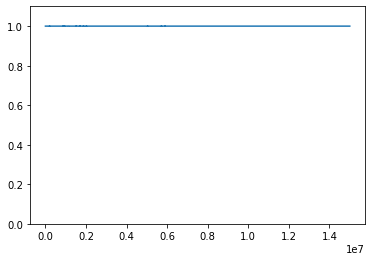

In [21]:
plt.plot(np.arange(number_droplets), np.exp(logarithmic_fudge_factor_upper_bounds))
plt.ylim((0,1.1))
plt.show()

In [22]:
np.savez_compressed('fudge_factors.npz',
                   approx_fudge=approx_logarithmic_fudge_factors,
                   lower_fudge=logarithmic_fudge_factor_lower_bounds,
                   upper_fudge=logarithmic_fudge_factor_upper_bounds)

In [23]:
import json

In [24]:
with open('droplet_indices.json', 'w') as file_pointer:
    json.dump(dict(droplet_indices), file_pointer, sort_keys=True)

In [25]:
len(droplet_indices[1])

2996

In [26]:
type(droplet_indices[1])

list

In [27]:
np.array(droplet_indices[1]).astype(int)

array([     793,     2812,     3598, ..., 14990012, 14997046, 14997796])

In [28]:
np.array(droplet_indices[1]).astype(int) - 1

array([     792,     2811,     3597, ..., 14990011, 14997045, 14997795])

(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 5.000e+00, 2.067e+03, 9.190e+02]),
 array([-6.31674787e-06, -5.60222139e-06, -4.88769490e-06, -4.17316842e-06,
        -3.45864194e-06, -2.74411546e-06, -2.02958898e-06, -1.31506249e-06,
        -6.00536012e-07,  1.13990470e-07,  8.28516952e-07]),
 <BarContainer object of 10 artists>)

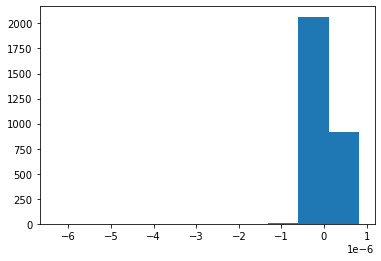

In [29]:
plt.hist(approx_logarithmic_fudge_factors[np.array(droplet_indices[1]).astype(int) - 1])

(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 5.000e+00, 2.067e+03, 9.190e+02]),
 array([0.99999368, 0.9999944 , 0.99999511, 0.99999583, 0.99999654,
        0.99999726, 0.99999797, 0.99999868, 0.9999994 , 1.00000011,
        1.00000083]),
 <BarContainer object of 10 artists>)

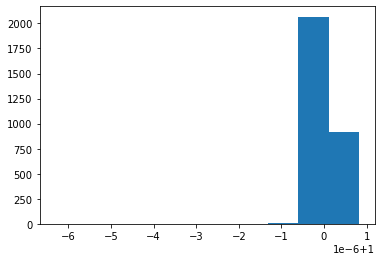

In [30]:
plt.hist(np.exp(approx_logarithmic_fudge_factors[np.array(droplet_indices[1]).astype(int) - 1]))

wow even for $.01\%$ relative abundance, the true probabilities vary from the replacement probabilities by no more than $1e-5$? And most less than $1e-6$? Honestly that seems kind of mental to me

Also note/recall that $\log(1 + x) \approx x$ for very small $x$, correspondingly when $\log(x) \approx 0$, $\exp(x) \approx 1 + x$, and we see that in the plots above. https://math.stackexchange.com/questions/1111041/showing-y%E2%89%88x-for-small-x-if-y-logx1

In [45]:
for index in range(len(freq_vector)):
    print("strain {}: {}".format(index+1, np.mean(approx_logarithmic_fudge_factors[np.array(droplet_indices[index]).astype(int) - 1])))

strain 1: 6.759914887944403e-08
strain 2: 6.43173014912285e-08
strain 3: 2.2604679029956187e-08
strain 4: 4.708250998954768e-08
strain 5: 1.8613256418668198e-08
strain 6: 2.3919268014412027e-08
strain 7: 3.0949362346883356e-08
strain 8: 3.800269385272225e-08
strain 9: 2.5965069391178423e-08
strain 10: 3.3876102400055876e-08
strain 11: 2.884568637021954e-08
strain 12: 3.1452245040106525e-08
strain 13: 2.953879560751837e-08
strain 14: 3.0975153633817275e-08
strain 15: 2.9702707423652638e-08
strain 16: 2.9198150427697477e-08
strain 17: 2.763986525897814e-08
strain 18: 2.753322661309632e-08
strain 19: 2.4837082980651143e-08
strain 20: 2.4917065823626934e-08
strain 21: 1.9942489727795264e-08
strain 22: 1.9829035396330723e-08
strain 23: 1.894135439253326e-08


OK, so while roughly speaking the trend _is_ that the approximations are worse for smaller relative abundances, like it is technically true but not like importantly true, so it seems

also shouldn't these be slightly negative instead of slightly positive? or have I misunderstood something

In [46]:
for index in range(len(freq_vector)):
    print("strain {}: {}".format(index+1, np.median(approx_logarithmic_fudge_factors[np.array(droplet_indices[index]).astype(int) - 1])))

strain 1: 6.06980654627165e-08
strain 2: 6.122169371458597e-08
strain 3: 5.787675316781815e-08
strain 4: 6.102413863118272e-08
strain 5: 5.812033210261802e-08
strain 6: 5.6978000984031496e-08
strain 7: 5.599780283915834e-08
strain 8: 5.651866441525044e-08
strain 9: 5.5716383950965565e-08
strain 10: 5.598168506537604e-08
strain 11: 5.4990087150486033e-08
strain 12: 5.5577883628643576e-08
strain 13: 5.410656189752672e-08
strain 14: 5.4354920564492204e-08
strain 15: 5.2132004935145915e-08
strain 16: 5.2286933449607886e-08
strain 17: 4.609142800759969e-08
strain 18: 4.609514681064297e-08
strain 19: 3.84241305440014e-08
strain 20: 3.849675600520186e-08
strain 21: 2.988484704147254e-08
strain 22: 2.985777491915087e-08
strain 23: 2.8593496459450307e-08


ok so this shows a _slightly_ less ambiguous decreasing trend but yeah still

In [47]:
for index in range(len(freq_vector)):
    print("strain {}: {}".format(index+1, np.mean(logarithmic_fudge_factor_lower_bounds[np.array(droplet_indices[index]).astype(int) - 1])))

strain 1: 5.756927327222901e-08
strain 2: 5.4161935517296694e-08
strain 3: 1.8737157912543324e-08
strain 4: 4.324243603995051e-08
strain 5: 1.647807096835978e-08
strain 6: 2.179862847728529e-08
strain 7: 2.908192595390282e-08
strain 8: 3.6123079209000517e-08
strain 9: 2.4152951462020784e-08
strain 10: 3.2066198223083895e-08
strain 11: 2.7049323493676636e-08
strain 12: 2.965049492258198e-08
strain 13: 2.7745048417028552e-08
strain 14: 2.918240428828761e-08
strain 15: 2.7912391979384103e-08
strain 16: 2.7408602077547067e-08
strain 17: 2.584888621040163e-08
strain 18: 2.5742306312906638e-08
strain 19: 2.3046891802592324e-08
strain 20: 2.3125955265371052e-08
strain 21: 1.8151729349848545e-08
strain 22: 1.803824111180656e-08
strain 23: 1.7151392531479953e-08


ok yeah again I thought these were supposed to be negative. it does suggest that the robbins things were usually negative though?

i mean so apparently this is saying that the sampling with replacement probability is _underestimating_ the true probability? does that even make sense? well first the difference is really small, but I guess it could happen if having removed other strains de facto (at least temporarily) slightly increases your relative abundance with respect to its initial value, so at least temporarily increasing the sampling probability, whereas it would remain fixed for sampling with replacement. Like the effect is biggest for the smallest relative abundance strains, right? corresponding to their probability getting inflated most, which makes sense, like if you sampled 10 million from all of the high abundance strains, and little to none of low abundance strains, your relative abundance might now be $.02\%$ or $.015\%$ instead of $.01\%$. Of course I would probably have to save more data in future iterations to test these hypotheses. But yeah these are not really the results I expected. Admittedly I was looking at the graphs of the wrong $\Phi$ functions, and focusing mostly on regimes that were "unphysical", so I would have ignored any small positive values like these because they looked the same as zero, but still you know

huh yeah it is weird I agree

In [48]:
for index in range(len(freq_vector)):
    print("strain {}: {}".format(index+1, np.median(logarithmic_fudge_factor_lower_bounds[np.array(droplet_indices[index]).astype(int) - 1])))

strain 1: 5.115503127839312e-08
strain 2: 5.138984354990792e-08
strain 3: 5.4229080991260504e-08
strain 4: 5.739333890395171e-08
strain 5: 5.612567974700583e-08
strain 6: 5.4756382203598186e-08
strain 7: 5.417580867412024e-08
strain 8: 5.455383797107289e-08
strain 9: 5.3932046207501067e-08
strain 10: 5.422193711810742e-08
strain 11: 5.314900544422152e-08
strain 12: 5.377348902106411e-08
strain 13: 5.232806588830374e-08
strain 14: 5.2549889451605726e-08
strain 15: 5.0315721900400184e-08
strain 16: 5.045350244278719e-08
strain 17: 4.425208169302528e-08
strain 18: 4.425597694989082e-08
strain 19: 3.656565508144754e-08
strain 20: 3.6654539354110966e-08
strain 21: 2.8054857014778005e-08
strain 22: 2.8018661865408714e-08
strain 23: 2.678127010964453e-08


huh that's bizarre you don't even have any clear decreasing trend until the largest relative abundances. it might be a quirk of the lower bound though, I don't know.

In [49]:
for index in range(len(freq_vector)):
    print("strain {}: {}".format(index+1, np.mean(logarithmic_fudge_factor_upper_bounds[np.array(droplet_indices[index]).astype(int) - 1])))
    

strain 1: 6.111773962069547e-08
strain 2: 5.782381298278628e-08
strain 3: 2.2293404423649322e-08
strain 4: 4.682296254465907e-08
strain 5: 2.006279004113778e-08
strain 6: 2.5356418782949786e-08
strain 7: 3.263701785295001e-08
strain 8: 3.970393770831841e-08
strain 9: 2.772563682555612e-08
strain 10: 3.56311372793344e-08
strain 11: 3.062338279312359e-08
strain 12: 3.3234190275569106e-08
strain 13: 3.131783517463996e-08
strain 14: 3.275260185305921e-08
strain 15: 3.1480342438937547e-08
strain 16: 3.097467012771675e-08
strain 17: 2.9418205900920285e-08
strain 18: 2.931189681843935e-08
strain 19: 2.66147413001055e-08
strain 20: 2.6695803935550663e-08
strain 21: 2.172076698563988e-08
strain 22: 2.1607550535547096e-08
strain 23: 2.071890232466911e-08


In [50]:
for index in range(len(freq_vector)):
    print("strain {}: {}".format(index+1, np.median(logarithmic_fudge_factor_upper_bounds[np.array(droplet_indices[index]).astype(int) - 1])))

strain 1: 5.410726988662755e-08
strain 2: 5.4884800992411773e-08
strain 3: 5.76401092853906e-08
strain 4: 6.08039797287351e-08
strain 5: 5.974557486607422e-08
strain 6: 5.845835303393168e-08
strain 7: 5.765265542975761e-08
strain 8: 5.835709337511134e-08
strain 9: 5.75202392670603e-08
strain 10: 5.782401271948415e-08
strain 11: 5.678838674198566e-08
strain 12: 5.74000880184636e-08
strain 13: 5.591890685802695e-08
strain 14: 5.6127076011565965e-08
strain 15: 5.3962054272523984e-08
strain 16: 5.4096015347572014e-08
strain 17: 4.79485804333332e-08
strain 18: 4.7943506175858496e-08
strain 19: 4.0256398052874206e-08
strain 20: 4.0333637838656006e-08
strain 21: 3.1701118073876604e-08
strain 22: 3.166974454698549e-08
strain 23: 3.0409624005421783e-08


yeah OK I don't think I have anything meaningfully different to say from what I've already said before. This honestly does just mostly confuse me though.

Also just think about how ridiculous this is -- apparently the true population size for the experiment would be **10 BILLION**? These ridiculously small number are only for $50$ **M**illion. like what, I can't even imagine how small they'd be for 10 billion.

and yes before you say anything yeah I don't have to imagine technically I could just run the simulation but apparently the multivariate hypergeometric implementation from numpy complains if you use a population larger than one billion and well. or you can supposedly use another implementation that doesn't care but the documentation seemed to scare and say that the other implementation is a lot slower except for very small numbers? ugh honestly I have no clue all of this kind of frustrates me frankly

In [57]:
for index in range(len(freq_vector)):
    print("strain {}: {}".format(index+1, np.exp(np.min(logarithmic_fudge_factor_lower_bounds[np.array(droplet_indices[index]).astype(int) -1  ]))))

strain 1: 0.999997748998145
strain 2: 0.9999936733558313
strain 3: 0.9998546844507336
strain 4: 0.9998909144356635
strain 5: 0.9999053633075708
strain 6: 0.9999033300935328
strain 7: 0.9999507700394882
strain 8: 0.9999575567438466
strain 9: 0.9999758944564535
strain 10: 0.9999764931002667
strain 11: 0.999957586567184
strain 12: 0.9999749954313932
strain 13: 0.9999791037736299
strain 14: 0.9999773324945936
strain 15: 0.9999394799848528
strain 16: 0.9998973941406852
strain 17: 0.9999706548096194
strain 18: 0.9999033300935328
strain 19: 0.9998973941406852
strain 20: 0.999908984397655
strain 21: 0.9998909144356635
strain 22: 0.9998973941406852
strain 23: 0.9999053633075708


hahhahahahahahaah

oh wow

i mean this is actually more ridiculous than even I expected like what

i mean it's unambiguously good news (at least after I double check code to make sure it's correct, although the results are largely similar to what I would expect) since it clearly shows that I don't need to even pretend to care about the probability distribution being incorrect for the simulations, like seriously the accuracy difference is WAY smaller than even I imagined

In [59]:
for index in range(len(freq_vector)):
    print("strain {}: {}".format(index+1, np.exp(np.max(logarithmic_fudge_factor_upper_bounds[np.array(droplet_indices[index]).astype(int) -1  ]))))

strain 1: 1.0000008051156501
strain 2: 1.0000008144244552
strain 3: 1.0000011685264847
strain 4: 1.0000010642851156
strain 5: 1.000001253859259
strain 6: 1.0000011313734458
strain 7: 1.0000011365020662
strain 8: 1.000001253859259
strain 9: 1.0000013637178735
strain 10: 1.000001364946716
strain 11: 1.0000011532083968
strain 12: 1.0000016018590145
strain 13: 1.0000012794216921
strain 14: 1.000001398316783
strain 15: 1.0000016018590145
strain 16: 1.0000016018590145
strain 17: 1.0000016018590145
strain 18: 1.000001534974574
strain 19: 1.0000016018590145
strain 20: 1.000001534974574
strain 21: 1.0000016018590145
strain 22: 1.0000016018590145
strain 23: 1.0000016018590145


hahahah oh wow OK yeah cool

I wanted to make some heat maps looking into all of this more closely, but basically all of the log values are nearly identically zero, and all of the exponentiated values are nearly identically one, even after having lopped off around 15 million of 50 million cells and yeah I just don't even know who I am anymore you know? like what the heck. like there isn't anything to report other than "oh yeah, basically everything is nearly exactly one, we can go home now"

well I guess maybe it would spare me from making the 2D heat maps/plots whatever of the hypothetical fudge factors? eh I don't know, do whatever you want, I don't really care myself personally so

In [60]:
np.sum(logarithmic_fudge_factor_lower_bounds < approx_logarithmic_fudge_factors)

15000000

In [61]:
np.sum(approx_logarithmic_fudge_factors < logarithmic_fudge_factor_upper_bounds)

14982135

hmmmm??? so the Robbins bounds error terms were always negative for the lower bounds, and only _usually_ positive for the upper bounds? I mean I guess that confirms my suspicion about the signs not really being possible to tell in advance necessarily but also at the same time then why are they all negative for the lower bounds or eh what? well anyway, median of approx and min of lower and max of upper would then seem to be decent summaries, at least for all but about $18,000$ droplets? and unless one of those are the maximum or whatever, which why would they be if they had a negative upper bound term... yeah it should be fine I think...